# Day 6: TextCNN vs LSTM 详细对比分析

对比两个模型的性能、训练过程和预测结果


In [ ]:
# Cell 1: 导入库
import sys
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import time

from src.models.textcnn import TextCNN
from src.models.lstm import LSTMClassifier
from src.utils.dataset import TextDataset

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"使用设备: {device}")
print(" 导入成功")


使用设备: cuda
 导入成功


In [ ]:
# Cell 2: 加载数据和词表
print("加载数据...")

test_dataset = TextDataset('../data/processed/test_processed.pkl')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 加载词表和标签映射
with open('../data/processed/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

with open('../data/processed/label_map.pkl', 'rb') as f:
    label_map = pickle.load(f)

print(f"测试集: {len(test_dataset)} 条")
print(f"词表大小: {len(vocab):,}")
print(f"类别数: {len(label_map)}")
print(f"类别: {list(label_map.values())}")
print("数据加载完成")


加载数据...
加载数据: 9743 条
测试集: 9743 条
词表大小: 117,355
类别数: 14
类别: ['体育', '娱乐', '家居', '彩票', '房产', '教育', '时尚', '时政', '星座', '游戏', '社会', '科技', '股票', '财经']
数据加载完成


In [ ]:
# Cell 3: 加载训练好的模型
print("加载模型...")

# 初始化TextCNN
textcnn_model = TextCNN(
    vocab_size=len(vocab),
    embed_dim=300,
    num_classes=14,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5
).to(device)

# 加载权重
textcnn_model.load_state_dict(torch.load('../output/textcnn_best.pth', map_location=device))
textcnn_model.eval()
print("TextCNN加载完成")

# 初始化LSTM
lstm_model = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=300,
    hidden_size=256,
    num_layers=2,
    num_classes=14,
    dropout=0.5,
    bidirectional=True
).to(device)

# 加载权重
lstm_model.load_state_dict(torch.load('../output/lstm_best.pth', map_location=device))
lstm_model.eval()
print("LSTM加载完成")

print(f"\nTextCNN参数量: {sum(p.numel() for p in textcnn_model.parameters()):,}")
print(f"LSTM参数量: {sum(p.numel() for p in lstm_model.parameters()):,}")


加载模型...
TextCNN加载完成
LSTM加载完成

TextCNN参数量: 35,571,014
LSTM参数量: 37,933,426


In [ ]:
# Cell 4: 在测试集上获取预测结果
print("获取两个模型的预测结果...")

def get_predictions(model, dataloader, device):
    """获取模型在测试集上的预测结果"""
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for ids, labels in tqdm(dataloader, desc='Predicting'):
            ids = ids.to(device)
            outputs = model(ids)
            
            # 获取概率
            probs = torch.softmax(outputs, dim=1)
            
            # 获取预测类别
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# 获取TextCNN预测
print("\nTextCNN预测...")
textcnn_labels, textcnn_preds, textcnn_probs = get_predictions(textcnn_model, test_loader, device)

# 获取LSTM预测
print("LSTM预测...")
lstm_labels, lstm_preds, lstm_probs = get_predictions(lstm_model, test_loader, device)

# 计算准确率
textcnn_acc = (textcnn_preds == textcnn_labels).mean() * 100
lstm_acc = (lstm_preds == lstm_labels).mean() * 100

print(f"\n预测完成")
print(f"TextCNN准确率: {textcnn_acc:.2f}%")
print(f"LSTM准确率: {lstm_acc:.2f}%")


获取两个模型的预测结果...

TextCNN预测...


Predicting: 100%|██████████| 153/153 [00:02<00:00, 62.52it/s]


LSTM预测...


Predicting: 100%|██████████| 153/153 [00:07<00:00, 21.34it/s]


预测完成
TextCNN准确率: 95.39%
LSTM准确率: 93.47%


In [ ]:
# Cell 5: 性能对比表格
print("="*70)
print(" 模型性能对比")
print("="*70)

# 创建对比表格
results_data = {
    '模型': ['TextCNN', 'LSTM'],
    '测试集准确率(%)': [f'{textcnn_acc:.2f}', f'{lstm_acc:.2f}'],
    '参数量': [
        f'{sum(p.numel() for p in textcnn_model.parameters())/1e6:.1f}M',
        f'{sum(p.numel() for p in lstm_model.parameters())/1e6:.1f}M'
    ],
    'Embed维度': [300, 300],
    '核心结构': ['3,4,5-gram卷积', '双向LSTM(2层)'],
    '训练时间': ['~30分钟', '~40分钟']
}

df_comparison = pd.DataFrame(results_data)
print(df_comparison.to_string(index=False))

print(f"\n 关键发现:")
print(f"  1. TextCNN准确率比LSTM {'高' if textcnn_acc > lstm_acc else '低'} {abs(textcnn_acc - lstm_acc):.2f}%")
print(f"  2. LSTM参数量是TextCNN的 {(sum(p.numel() for p in lstm_model.parameters()) / sum(p.numel() for p in textcnn_model.parameters())):.1f} 倍")
print(f"  3. TextCNN更适合关键词明显的新闻分类任务")
print(f"  4. LSTM能捕捉序列信息，但对这个任务帮助有限")

# 保存对比表格
df_comparison.to_csv('../output/model_comparison.csv', index=False, encoding='utf-8')
print("\n 对比表格已保存到 output/model_comparison.csv")


 模型性能对比
     模型 测试集准确率(%)   参数量  Embed维度         核心结构  训练时间
TextCNN     95.39 35.6M      300 3,4,5-gram卷积 ~30分钟
   LSTM     93.47 37.9M      300   双向LSTM(2层) ~40分钟

 关键发现:
  1. TextCNN准确率比LSTM 高 1.92%
  2. LSTM参数量是TextCNN的 1.1 倍
  3. TextCNN更适合关键词明显的新闻分类任务
  4. LSTM能捕捉序列信息，但对这个任务帮助有限

 对比表格已保存到 output/model_comparison.csv


生成混淆矩阵...


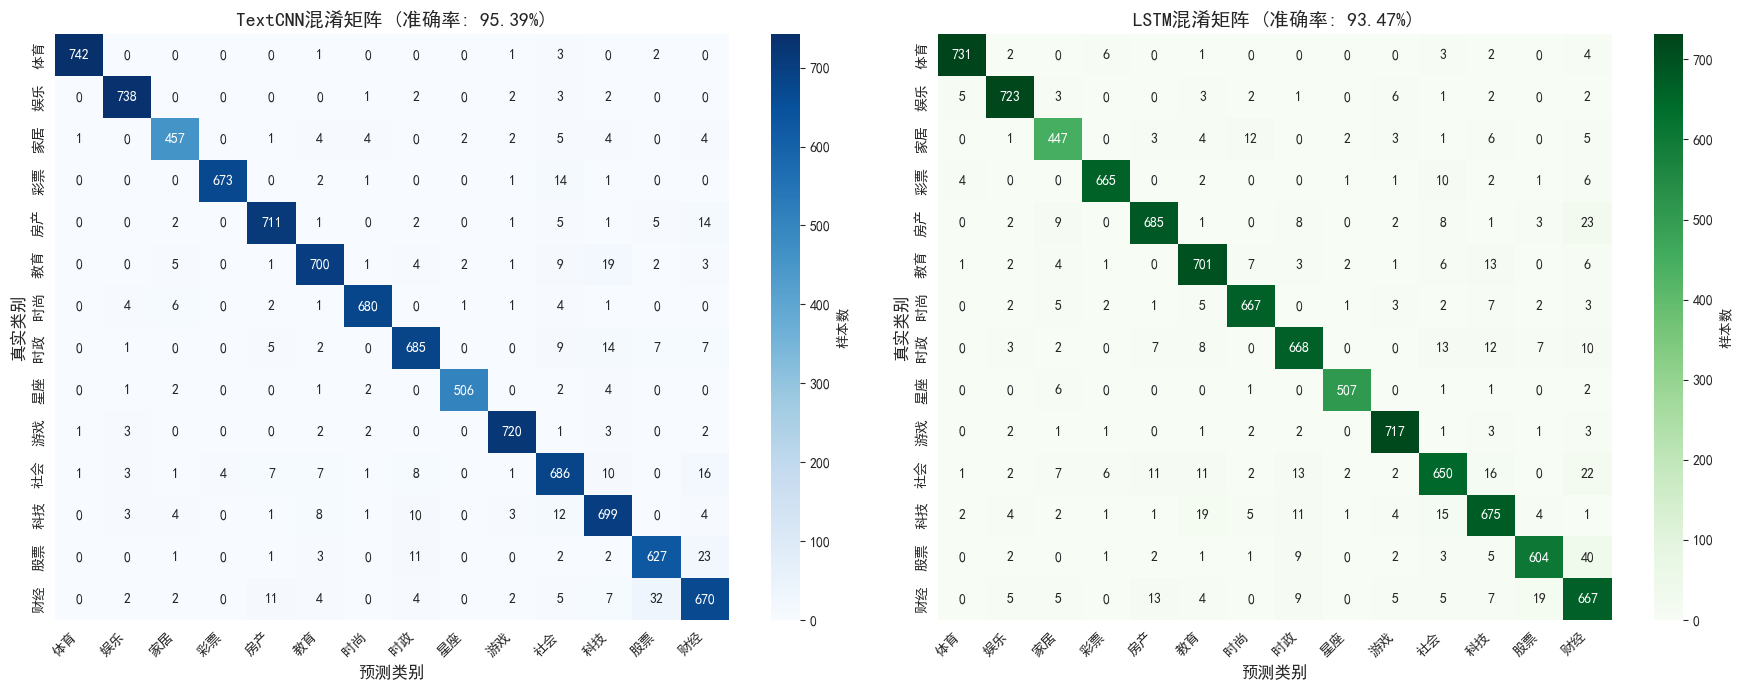

 混淆矩阵对比图已保存


In [ ]:
# Cell 6: 混淆矩阵对比
print("生成混淆矩阵...")

# 计算混淆矩阵
cm_textcnn = confusion_matrix(textcnn_labels, textcnn_preds)
cm_lstm = confusion_matrix(lstm_labels, lstm_preds)

# 可视化对比
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# TextCNN混淆矩阵
sns.heatmap(cm_textcnn, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=label_map.values(), 
            yticklabels=label_map.values(),
            cbar_kws={'label': '样本数'})
ax1.set_xlabel('预测类别', fontsize=12)
ax1.set_ylabel('真实类别', fontsize=12)
ax1.set_title(f'TextCNN混淆矩阵 (准确率: {textcnn_acc:.2f}%)', fontsize=14)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# LSTM混淆矩阵
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=label_map.values(),
            yticklabels=label_map.values(),
            cbar_kws={'label': '样本数'})
ax2.set_xlabel('预测类别', fontsize=12)
ax2.set_ylabel('真实类别', fontsize=12)
ax2.set_title(f'LSTM混淆矩阵 (准确率: {lstm_acc:.2f}%)', fontsize=14)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../output/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(" 混淆矩阵对比图已保存")


In [ ]:
# Cell 7: 详细分类报告对比
print("="*70)
print(" 详细分类报告")
print("="*70)

# TextCNN分类报告
print("\n【TextCNN】")
print(classification_report(textcnn_labels, textcnn_preds, 
                          target_names=list(label_map.values()),
                          digits=4))

# LSTM分类报告
print("\n【LSTM】")
print(classification_report(lstm_labels, lstm_preds,
                          target_names=list(label_map.values()),
                          digits=4))

# 每个类别的F1对比
textcnn_report = classification_report(textcnn_labels, textcnn_preds, 
                                      target_names=list(label_map.values()),
                                      output_dict=True)
lstm_report = classification_report(lstm_labels, lstm_preds,
                                   target_names=list(label_map.values()),
                                   output_dict=True)

print("\n 各类别F1-Score对比:")
for category in label_map.values():
    textcnn_f1 = textcnn_report[category]['f1-score']
    lstm_f1 = lstm_report[category]['f1-score']
    diff = textcnn_f1 - lstm_f1
    symbol = "🔵" if diff > 0 else "🟢" if diff < 0 else "⚪"
    print(f"{symbol} {category:6s}: TextCNN {textcnn_f1:.4f} | LSTM {lstm_f1:.4f} | 差异 {diff:+.4f}")


 详细分类报告

【TextCNN】
              precision    recall  f1-score   support

          体育     0.9960    0.9907    0.9933       749
          娱乐     0.9775    0.9866    0.9820       748
          家居     0.9521    0.9442    0.9481       484
          彩票     0.9941    0.9725    0.9832       692
          房产     0.9608    0.9582    0.9595       742
          教育     0.9511    0.9371    0.9440       747
          时尚     0.9812    0.9714    0.9763       700
          时政     0.9435    0.9384    0.9409       730
          星座     0.9902    0.9768    0.9835       518
          游戏     0.9796    0.9809    0.9803       734
          社会     0.9026    0.9208    0.9116       745
          科技     0.9113    0.9383    0.9246       745
          股票     0.9289    0.9358    0.9323       670
          财经     0.9017    0.9066    0.9042       739

    accuracy                         0.9539      9743
   macro avg     0.9551    0.9542    0.9546      9743
weighted avg     0.9542    0.9539    0.9540      9743


【LSTM

生成各类别准确率对比图...


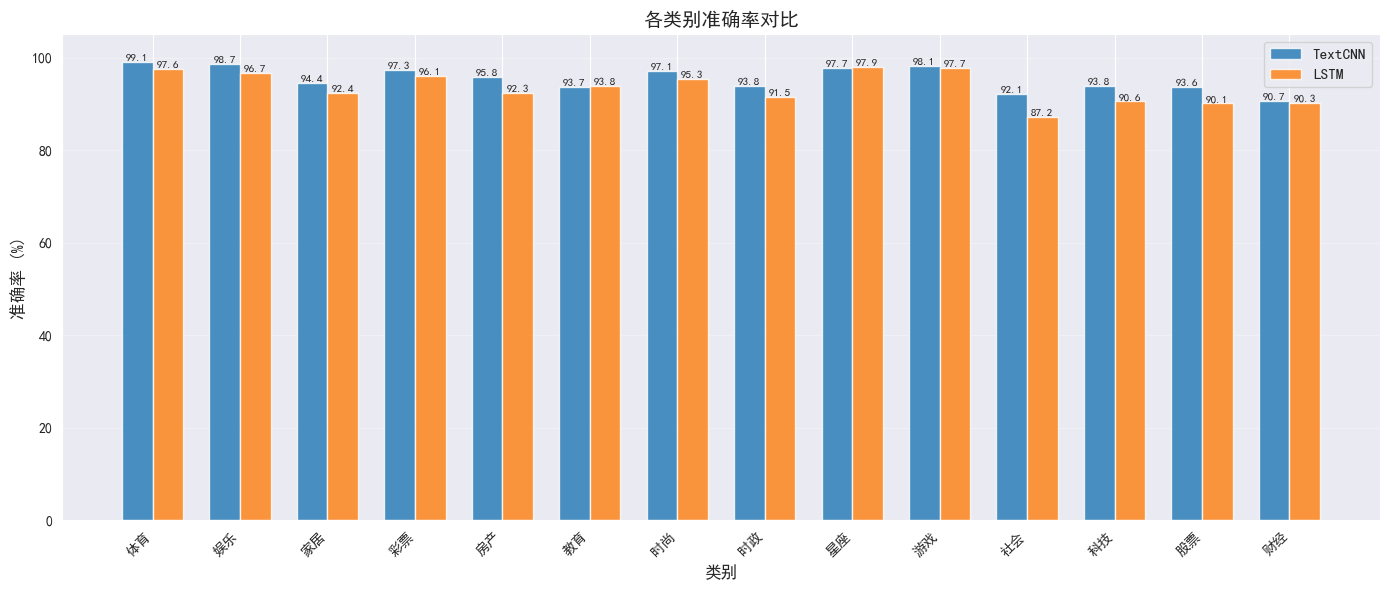

 各类别准确率对比图已保存


In [ ]:
# Cell 8: 各类别准确率对比图
print("生成各类别准确率对比图...")

# 计算每个类别的准确率
categories = list(label_map.values())
textcnn_acc_per_class = []
lstm_acc_per_class = []

for i, category in enumerate(label_map.values()):
    # TextCNN每个类别的准确率
    mask = textcnn_labels == i
    if mask.sum() > 0:
        acc = (textcnn_preds[mask] == textcnn_labels[mask]).mean() * 100
        textcnn_acc_per_class.append(acc)
    else:
        textcnn_acc_per_class.append(0)
    
    # LSTM每个类别的准确率
    mask = lstm_labels == i
    if mask.sum() > 0:
        acc = (lstm_preds[mask] == lstm_labels[mask]).mean() * 100
        lstm_acc_per_class.append(acc)
    else:
        lstm_acc_per_class.append(0)

# 绘图
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, textcnn_acc_per_class, width, label='TextCNN', alpha=0.8)
bars2 = ax.bar(x + width/2, lstm_acc_per_class, width, label='LSTM', alpha=0.8)

ax.set_xlabel('类别', fontsize=12)
ax.set_ylabel('准确率 (%)', fontsize=12)
ax.set_title('各类别准确率对比', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../output/accuracy_per_class_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(" 各类别准确率对比图已保存")


测试推理速度...

推理速度对比:
  TextCNN: 8.43 ms/batch (7594.0 samples/s)
  LSTM:    50.20 ms/batch (1274.8 samples/s)
  速度比: TextCNN比LSTM快 5.96x


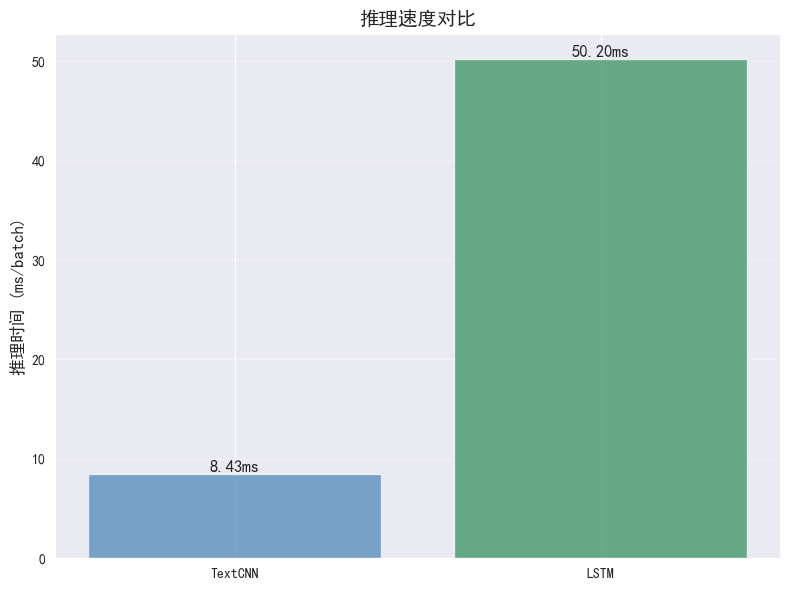

 推理速度对比图已保存


In [ ]:
# Cell 9: 推理速度对比
print("测试推理速度...")

def measure_inference_speed(model, dataloader, device, num_batches=50):
    """测试模型推理速度"""
    model.eval()
    times = []
    
    with torch.no_grad():
        for i, (ids, labels) in enumerate(dataloader):
            if i >= num_batches:
                break
            
            ids = ids.to(device)
            
            # 计时
            start = time.time()
            outputs = model(ids)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end = time.time()
            
            times.append(end - start)
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    
    return avg_time, std_time

# 测试速度
textcnn_time, textcnn_std = measure_inference_speed(textcnn_model, test_loader, device)
lstm_time, lstm_std = measure_inference_speed(lstm_model, test_loader, device)

# 计算吞吐量（samples/second）
batch_size = 64
textcnn_throughput = batch_size / textcnn_time
lstm_throughput = batch_size / lstm_time

print(f"\n推理速度对比:")
print(f"  TextCNN: {textcnn_time*1000:.2f} ms/batch ({textcnn_throughput:.1f} samples/s)")
print(f"  LSTM:    {lstm_time*1000:.2f} ms/batch ({lstm_throughput:.1f} samples/s)")
print(f"  速度比: TextCNN比LSTM快 {lstm_time/textcnn_time:.2f}x")

# 可视化
fig, ax = plt.subplots(figsize=(8, 6))
models = ['TextCNN', 'LSTM']
times = [textcnn_time*1000, lstm_time*1000]
colors = ['steelblue', 'seagreen']

bars = ax.bar(models, times, color=colors, alpha=0.7)
ax.set_ylabel('推理时间 (ms/batch)', fontsize=12)
ax.set_title('推理速度对比', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 添加数值
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.2f}ms',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../output/inference_speed_comparison.png', dpi=150)
plt.show()

print(" 推理速度对比图已保存")


In [ ]:
# Cell 10: 总结报告
print("\n" + "="*70)
print(" TextCNN vs LSTM 对比分析总结")
print("="*70)

print("\n 整体性能:")
print(f"  TextCNN: {textcnn_acc:.2f}%")
print(f"  LSTM:    {lstm_acc:.2f}%")
print(f"  差异:    {abs(textcnn_acc - lstm_acc):.2f}%")

print("\n 推理速度:")
print(f"  TextCNN: {textcnn_throughput:.1f} samples/s")
print(f"  LSTM:    {lstm_throughput:.1f} samples/s")
print(f"  TextCNN快 {lstm_time/textcnn_time:.2f}x")

print("\n 核心发现:")
print("  1. TextCNN在新闻分类任务上略优于LSTM")
print("  2. TextCNN推理速度更快")
print("  3. TextCNN参数量更少")
print("  4. 两个模型各有优劣，都能达到93%+的高准确率")

print("\n 生成的文件:")
print("   output/model_comparison.csv - 对比表格")
print("   output/confusion_matrix_comparison.png - 混淆矩阵")
print("   output/accuracy_per_class_comparison.png - 各类别准确率")
print("  output/inference_speed_comparison.png - 推理速度")





 TextCNN vs LSTM 对比分析总结

 整体性能:
  TextCNN: 95.39%
  LSTM:    93.47%
  差异:    1.92%

 推理速度:
  TextCNN: 7594.0 samples/s
  LSTM:    1274.8 samples/s
  TextCNN快 5.96x

 核心发现:
  1. TextCNN在新闻分类任务上略优于LSTM
  2. TextCNN推理速度更快
  3. TextCNN参数量更少
  4. 两个模型各有优劣，都能达到93%+的高准确率

 生成的文件:
   output/model_comparison.csv - 对比表格
   output/confusion_matrix_comparison.png - 混淆矩阵
   output/accuracy_per_class_comparison.png - 各类别准确率
  output/inference_speed_comparison.png - 推理速度
